In [1]:
import os
import warnings
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, expon

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

In [3]:
data.head(20)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166,1056.25,113,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103,1173.75,92,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131,1140.00,114,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172,1092.00,122,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131,1205.00,116,1490.00,1110.00,11.150,59.575001,0.788794
5,1.2,1197.00,38,4.741012,750.25,89,1336.50,96,1393.00,949.25,11.175,59.175000,0.784772
6,1.2,1185.00,31,3.624399,689.50,62,1461.75,77,1332.75,732.50,11.325,56.775000,0.760312
7,1.0,1136.25,31,3.326677,672.00,62,1453.25,76,1332.75,729.50,10.675,60.000000,0.770238
8,0.9,1094.00,24,2.339416,608.50,45,1579.00,60,1276.00,619.50,10.650,59.674999,0.764819
9,0.7,1066.00,8,1.133431,512.00,16,1918.00,28,1182.00,421.75,11.000,56.175000,0.736560


In [4]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

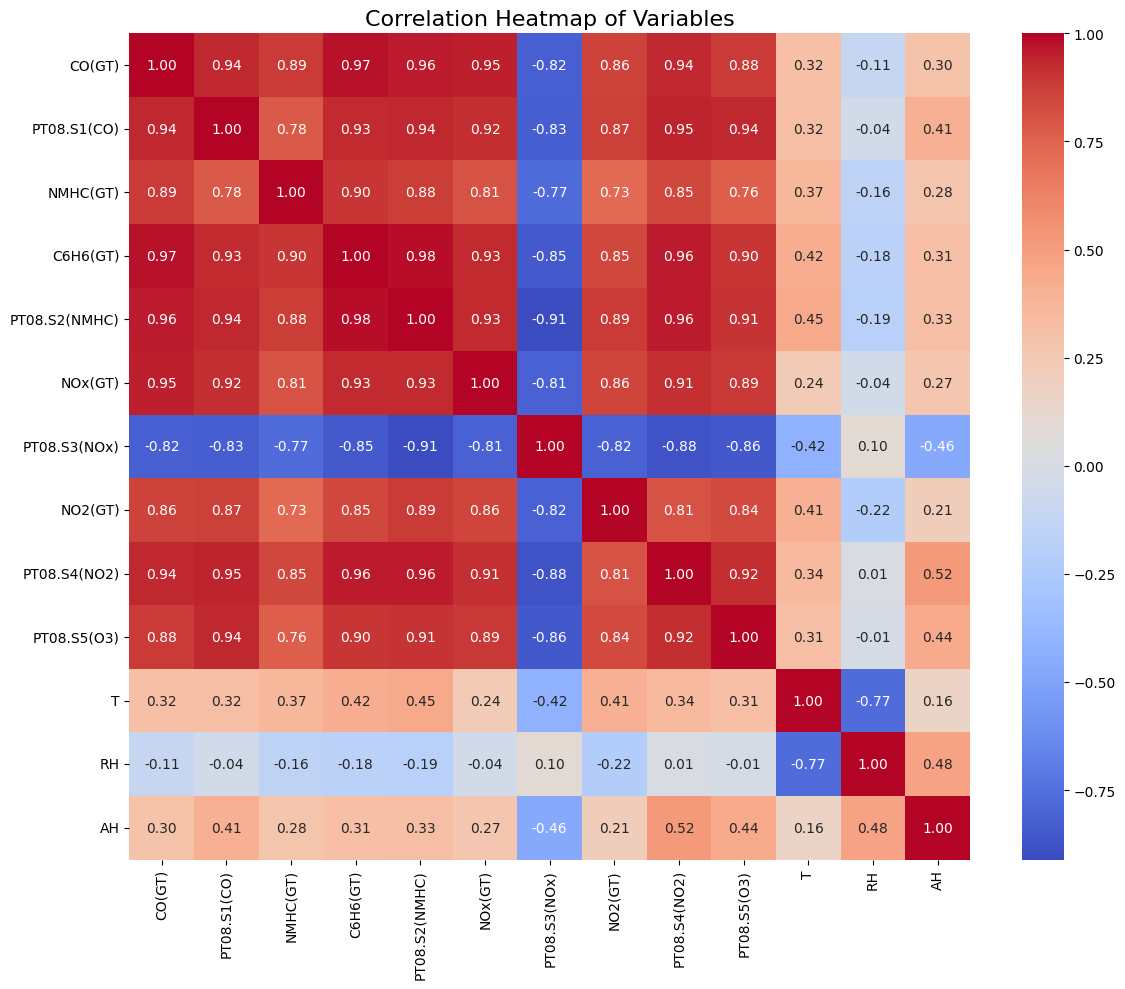

In [5]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_after_transformation.png")
plt.show()


In [6]:
# Define the target and predictor variables
target_variable = 'C6H6(GT)'
predictor_variables = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Subset the data to include only the target and predictor variables
data = data[[target_variable] + predictor_variables].dropna()

# Prepare predictors and target
X = data[predictor_variables]
y = data[target_variable]

# Ensure the target variable contains only positive values
if (y <= 0).any():
    print("Target variable contains non-positive values. Adjusting...")
    y += 0.001  # Add a small constant to ensure positivity

# Define the Bayesian Gamma Regression Model
with pm.Model() as gamma_model:
    # Priors for the coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Linear predictor
    mu = pm.math.exp(pm.math.dot(X.values, beta) + intercept)
    alpha = pm.HalfCauchy("alpha", beta=2)  # Shape parameter
    
    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y.values)
    
    # Initialize model with a custom start point
    initial_point = gamma_model.initial_point()
    initial_point["alpha"] = 1.0  # Positive initial value for alpha
    initial_point["beta"] = np.zeros(X.shape[1])  # Start with all coefficients at 0
    initial_point["intercept"] = np.log(np.mean(y))  # Approximate initial intercept
    
    # Sampling
    idata = pm.sample(1000, tune=500, init="adapt_diag", start=initial_point, return_inferencedata=True)

# Summarize the posterior
summary = idata.posterior.to_dataframe()
summary.head()


Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, intercept, alpha]


Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 109 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


beta  intercept       alpha
chain draw beta_dim_0                                 
0     0    0          -0.095225   1.383153  131.234595
           1           0.000394   1.383153  131.234595
           2          -0.000562   1.383153  131.234595
           3           0.003053   1.383153  131.234595
           4          -0.000095   1.383153  131.234595

In [25]:
summary.head(20)

beta  intercept       alpha
chain draw beta_dim_0                                 
0     0    0          -0.095225   1.383153  131.234595
           1           0.000394   1.383153  131.234595
           2          -0.000562   1.383153  131.234595
           3           0.003053   1.383153  131.234595
           4          -0.000095   1.383153  131.234595
           5          -0.001429   1.383153  131.234595
           6           0.002204   1.383153  131.234595
           7          -0.000629   1.383153  131.234595
           8          -0.000235   1.383153  131.234595
           9           0.005550   1.383153  131.234595
           10          0.004818   1.383153  131.234595
           11         -0.308647   1.383153  131.234595
      1    0          -0.106216   1.466543  112.512415
           1           0.000474   1.466543  112.512415
           2          -0.000442   1.466543  112.512415
           3           0.002774   1.466543  112.512415
           4          -0.000205   1.466543  112.512415
           5          -0.001476   1.466543  112.512415
           6           0.002520   1.466543  112.512415
           7          -0.000549   1.466543  112.512415

In [ ]:
# summary.to_excel("first_model.xlsx")

In [26]:
summary["beta"].max()

0.01902184150622948